In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

module_path = (Path().resolve().parent/ "Modules")
sys.path.append(str(module_path))

import my_modules, model_tuner, model_tuner_multi, features, skill_calculators, feature_selector
pd.set_option("display.max_columns", None)
pd.option_context(
        'display.max_info_rows', None,     # 行しきい値を無制限
        'display.max_info_columns', None
        )

plt.rcParams['font.family'] = 'Yu Gothic'

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
df = pd.read_csv("../Data/train_data_JV_2008.csv", encoding="cp932")
# odds_df = pd.read_csv("../Data/Time_Series_Odds_win_odds.csv", encoding="shift-jis")

In [3]:
df2 = my_modules.preprocessing(df)

In [4]:
df3 = my_modules.common_process(df2)

C:\Users\ken05\Documents\others\HORSE_RACING\Modules\my_modules.py:77: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["place_num"] = df["place"].replace(place_dict).astype(int)


In [5]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 829624 entries, 830948 to 0
Data columns (total 71 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   race_id              829624 non-null  int64         
 1   year                 829624 non-null  int64         
 2   month                829624 non-null  int64         
 3   day                  829624 non-null  int64         
 4   times                829624 non-null  int32         
 5   place                829624 non-null  object        
 6   daily                829624 non-null  object        
 7   race_num             829624 non-null  int64         
 8   horse                829624 non-null  object        
 9   jockey_id            829624 non-null  object        
 10  trainer_id           829624 non-null  int64         
 11  owner                829624 non-null  object        
 12  breeding_farm        829624 non-null  object        
 13  breeding_place     

In [6]:
# 計算に時間がかかりすぎるので、とりあえず2020年からのデータをつかって実験
df3 = df3[df3.year >= 2018]

In [7]:
feature_col = []
ranking_col = []
df4, feature_col2, ranking_col2 = skill_calculators.all_rating_calculator(df3, feature_col, ranking_col)

calculating horse trueskill is in progress
calculating jockey trueskill is in progress
calculating horse EloRating is in progress
calculating jockey EloRating is in progress
calculating Glicko2 is in progress
poly calculated


In [9]:
feature_col2.extend(["waku_num", "horse_num", "sex", "age", "basis_weight", "weight", "inc_dec", "age_type"])
df5, feature_col3 = features.sub_feature_engineering(df4, feature_col2, ranking_col2)

calc grouped rating caluculated
group_winning_rate_calculated
added last odds
num_col are standardize
calculated rankings


KeyError: 'day_of_week'

In [ ]:
df5[feature_col3]

,horse_TrueSkill,horse_TrueSkill_sigma,horse_TrueSkill_min,horse_TrueSkill_max,jockey_TrueSkill,jockey_TrueSkill_sigma,jockey_TrueSkill_min,jockey_TrueSkill_max,horse_EloRating,jockey_EloRating,horse_Glicko2,horse_Glicko2_RD,horse_Glicko2_min,horse_Glicko2_max,horse_TrueSkill_diff_from_last1_racing,horse_TrueSkill_diff_from_last3_racing,jockey_TrueSkill_diff_from_last1_racing,jockey_TrueSkill_diff_from_last3_racing,horse_EloRating_diff_from_last1_racing,horse_EloRating_diff_from_last3_racing,jockey_EloRating_diff_from_last1_racing,jockey_EloRating_diff_from_last3_racing,horse_Glicko2_diff_from_last1_racing,horse_Glicko2_diff_from_last3_racing,horse_TrueSkill horse_TrueSkill_min,horse_TrueSkill horse_TrueSkill_max,horse_TrueSkill jockey_TrueSkill,horse_TrueSkill jockey_TrueSkill_min,horse_TrueSkill jockey_TrueSkill_max,horse_TrueSkill horse_EloRating,horse_TrueSkill jockey_EloRating,horse_TrueSkill horse_Glicko2,horse_TrueSkill horse_Glicko2_min,horse_TrueSkill horse_Glicko2_max,horse_TrueSkill_min horse_TrueSkill_max,horse_TrueSkill_min jockey_TrueSkill,horse_TrueSkill_min jockey_TrueSkill_min,horse_TrueSkill_min jockey_TrueSkill_max,horse_TrueSkill_min horse_EloRating,horse_TrueSkill_min jockey_EloRating,horse_TrueSkill_min horse_Glicko2,horse_TrueSkill_min horse_Glicko2_min,horse_TrueSkill_min horse_Glicko2_max,horse_TrueSkill_max jockey_TrueSkill,horse_TrueSkill_max jockey_TrueSkill_min,horse_TrueSkill_max jockey_TrueSkill_max,horse_TrueSkill_max horse_EloRating,horse_TrueSkill_max jockey_EloRating,horse_TrueSkill_max horse_Glicko2,horse_TrueSkill_max horse_Glicko2_min,horse_TrueSkill_max horse_Glicko2_max,jockey_TrueSkill jockey_TrueSkill_min,jockey_TrueSkill jockey_TrueSkill_max,jockey_TrueSkill horse_EloRating,jockey_TrueSkill jockey_EloRating,jockey_TrueSkill horse_Glicko2,jockey_TrueSkill horse_Glicko2_min,jockey_TrueSkill horse_Glicko2_max,jockey_TrueSkill_min jockey_TrueSkill_max,jockey_TrueSkill_min horse_EloRating,jockey_TrueSkill_min jockey_EloRating,jockey_TrueSkill_min horse_Glicko2,jockey_TrueSkill_min horse_Glicko2_min,jockey_TrueSkill_min horse_Glicko2_max,jockey_TrueSkill_max horse_EloRating,jockey_TrueSkill_max jockey_EloRating,jockey_TrueSkill_max horse_Glicko2,jockey_TrueSkill_max horse_Glicko2_min,jockey_TrueSkill_max horse_Glicko2_max,horse_EloRating jockey_EloRating,horse_EloRating horse_Glicko2,horse_EloRating horse_Glicko2_min,horse_EloRating horse_Glicko2_max,jockey_EloRating horse_Glicko2,jockey_EloRating horse_Glicko2_min,jockey_EloRating horse_Glicko2_max,horse_Glicko2 horse_Glicko2_min,horse_Glicko2 horse_Glicko2_max,horse_Glicko2_min horse_Glicko2_max,waku_num,horse_num,sex,age,basis_weight,weight,inc_dec,age_type,weight_last_1,weight_last_2,weight_last_3,weight_mean_last_1_to_3,weight_mean_all,inc_dec_last_1,inc_dec_last_2,inc_dec_last_3,inc_dec_mean_last_1_to_3,inc_dec_mean_all,last_3F_time_last_1,last_3F_time_last_2,last_3F_time_last_3,last_3F_time_mean_last_1_to_3,last_3F_time_mean_all,Ave_3F_last_1,Ave_3F_last_2,Ave_3F_last_3,Ave_3F_mean_last_1_to_3,Ave_3F_mean_all,num_of_entries,後方_per_entries,後方_cumcount_past_racing,中団_per_entries,中団_cumcount_past_racing,逃げ_per_entries,逃げ_cumcount_past_racing,先行_per_entries,先行_cumcount_past_racing,ﾏｸﾘ_per_entries,ﾏｸﾘ_cumcount_past_racing,past_rank_mean,past_rank_mean_grouped_waku,past_rank_mean_grouped_dist_type,past_rank_mean_grouped_dist,past_rank_mean_grouped_class_code,past_rank_mean_grouped_place,past_rank_mean_grouped_dist_type_waku,past_corner1_rank_mean,past_corner1_rank_mean_grouped_dist_type,past_corner1_rank_mean_grouped_dist,past_corner2_rank_mean,past_corner2_rank_mean_grouped_dist_type,past_corner2_rank_mean_grouped_dist,past_corner3_rank_mean,past_corner3_rank_mean_grouped_dist_type,past_corner3_rank_mean_grouped_dist,past_corner4_rank_mean,past_corner4_rank_mean_grouped_dist_type,past_corner4_rank_mean_grouped_dist,past_pop_mean,past_pop_mean_grouped_dist,past_pop_mean_grouped_dist_type,past_pop_mean_grouped_place,past_pop_mean_grouped_cl

In [ ]:
# まだ大丈夫そうなので、いったん凍結
# df6, feature_col4 = feature_selector.select_from_model(df5, feature_col3)
# df6[feature_col4].head()

[I 2025-07-27 23:57:45,729] A new study created in memory with name: no-name-8a150478-b08b-4e8f-875e-b47de7f64cf4
[I 2025-07-27 23:58:00,279] Trial 0 finished with value: 0.6664234931820353 and parameters: {'max_bin': 102, 'num_leaves': 96, 'min_data_in_leaf': 79, 'min_sum_hessian_in_leaf': 5.9865848459837805, 'bagging_fraction': 0.46240745617697465, 'bagging_freq': 16, 'feature_fraction': 0.15227525095137953, 'lambda_l1': 4.589458612326471, 'lambda_l2': 0.010260065124896791, 'min_gain_to_split': 7.080725777960454, 'max_depth': 4, 'learning_rate': 0.41472250004816347, 'path_smooth': 4.329770563201687, 'feature_fraction_bynode': 0.6424678221356552, 'extra_trees': False}. Best is trial 0 with value: 0.6664234931820353.
[I 2025-07-27 23:59:43,771] Trial 1 finished with value: 0.6623584021448455 and parameters: {'max_bin': 84, 'num_leaves': 53, 'min_data_in_leaf': 54, 'min_sum_hessian_in_leaf': 2.9122914090681276, 'bagging_fraction': 0.6447411578889518, 'bagging_freq': 14, 'feature_fractio

Best params :  {'max_bin': 144, 'num_leaves': 20, 'min_data_in_leaf': 98, 'min_sum_hessian_in_leaf': 7.751328235859817, 'bagging_fraction': 0.7757995766256757, 'bagging_freq': 90, 'feature_fraction': 0.6381099809299766, 'lambda_l1': 16.547879518482567, 'lambda_l2': 7.672290184186785e-08, 'min_gain_to_split': 1.959828624191452, 'max_depth': 6, 'learning_rate': 0.007551909976018511, 'path_smooth': 2.554709158757928, 'feature_fraction_bynode': 0.6542698063547792, 'extra_trees': True}


Before Calibrating Train Logloss: 0.6471696084928149
Before Calibrating Test  Logloss: 0.6544880669662296
Calibrated Train Logloss: 0.6544857150312046
Calibrated Test  Logloss 0.6360996864000228
↑これらは正規化する前のデータを用いていることに注意


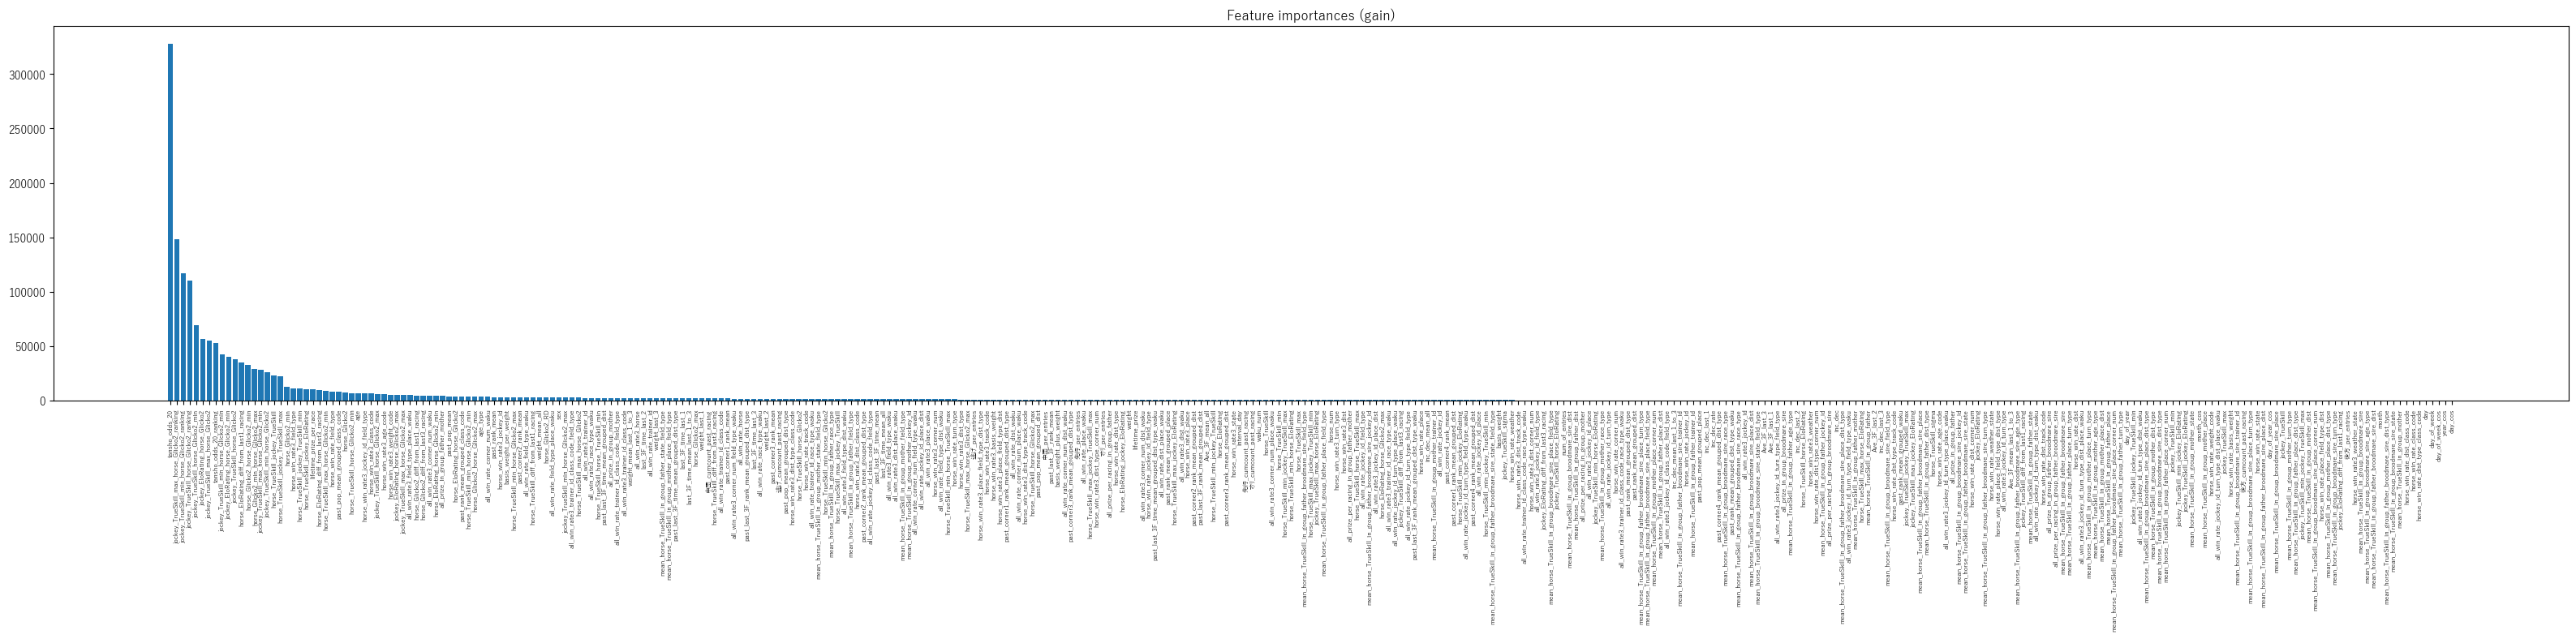

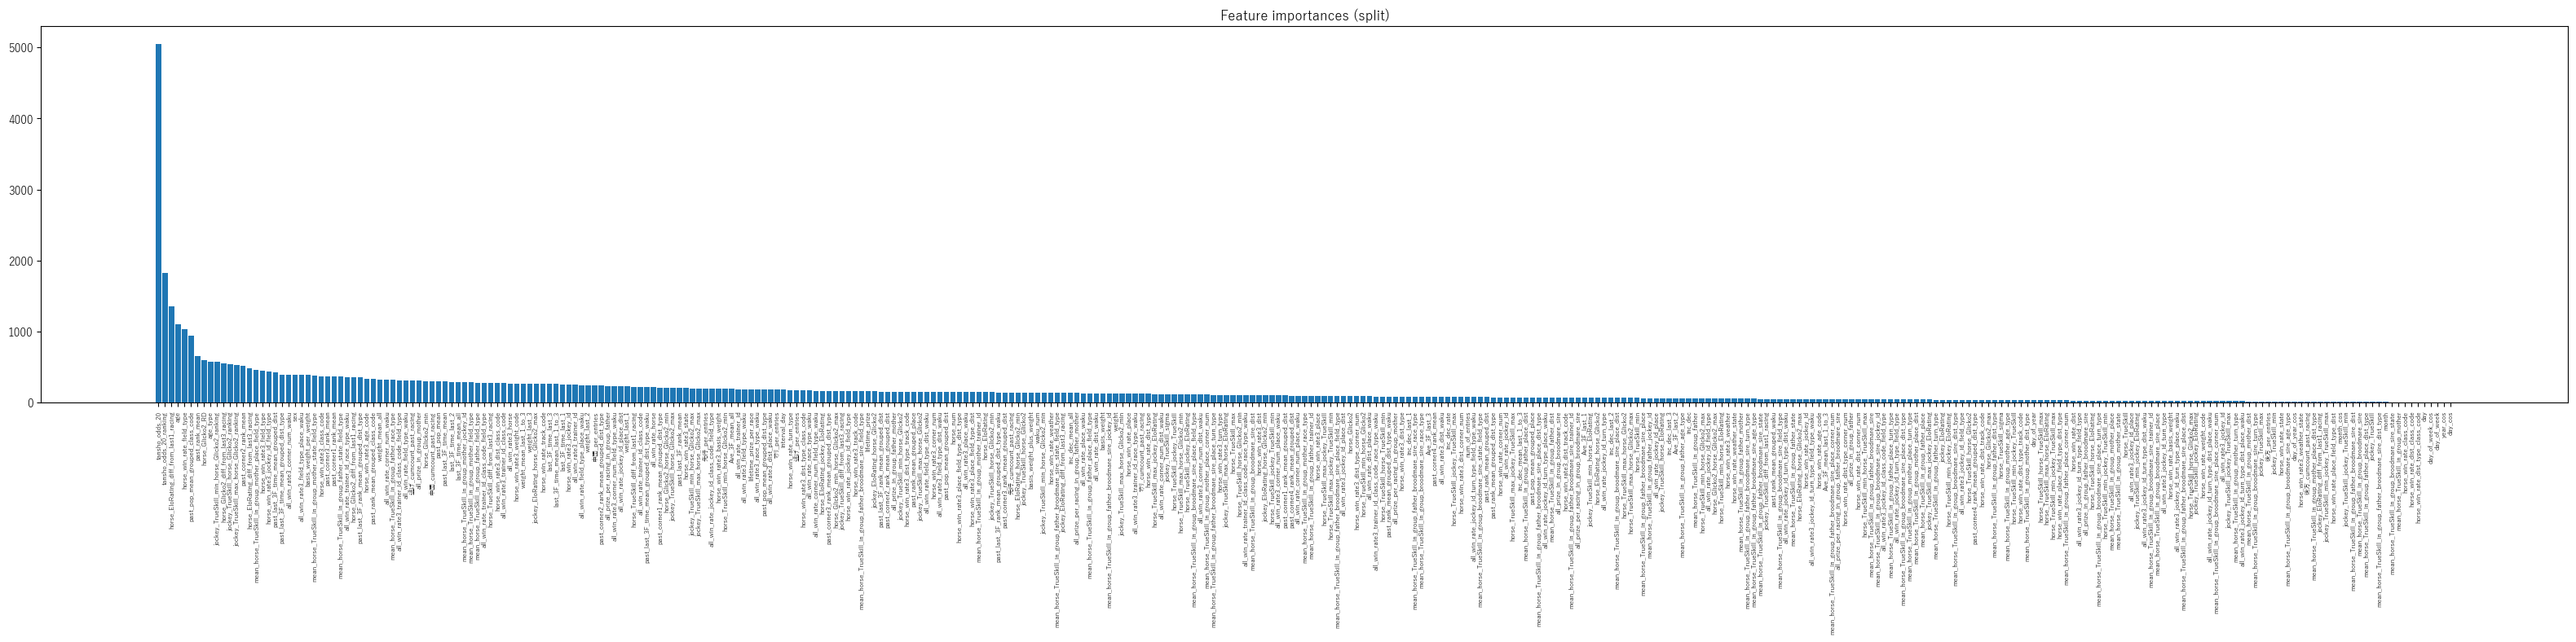

logloss is saved
auc_score is saved


,date,memo,horse_5,horse_6,horse_7,horse_8,horse_9,horse_10,horse_11,horse_12,horse_13,horse_14,horse_15,horse_16,horse_17,horse_18,all_logloss,auc(ovr)
0,2025/07/28 00:11,"add date feature (include cosine), n_trials = 100",1.400343,1.166908,0.972832,0.989009,0.886429,0.812746,0.757796,0.715112,0.683836,0.658406,0.625769,0.589791,0.571769,0.542683,0.636100,0.768342
0,2025/07/27 22:58,"remove feature_selection, n_trials = 100",1.396063,1.167348,0.970631,0.988094,0.886487,0.812203,0.758329,0.715028,0.683844,0.658572,0.626027,0.589826,0.570306,0.543128,0.636150,0.768174
1,2025/07/09 23:07,"base_model + feature selection with lightGBM, ...",1.397638,1.103793,0.974872,1.001259,0.899075,0.826686,0.768233,0.717613,0.690333,0.661422,0.627223,0.585965,0.567836,0.533686,0.639863,0.768683
2,2025/07/09 15:38,"base_model + feature selection with lightGBM, ...",1.397638,1.103793,0.974872,1.001259,0.899075,0.826686,0.768233,0.717613,0.690333,0.661422,0.627223,0.585965,0.567836,0.533686,0.639863,0.768683
3,2025/07/09 13:44,"base_model + feature selection with lightGBM, ...",1.406849,1.101321,0.977155,1.002813,0.899535,0.827626,0.769064,0.716093,0.690490,0.660548,0.627335,0.586272,0.567926,0.533438,0.639926,0.768559


In [ ]:
memo = "add date feature (include cosine), n_trials = 100"
model, df_pred = model_tuner_multi.multi_lightGBM(df5, feature_col3, memo=memo, n_trials=100, save_result=True, visualization=True)

In [ ]:
tmp = df_pred[["year", "month", "day", "horse", "pred_class_1", "pred_class_2", "pred_class_3", "target"]]
tmp

[autoreload of my_modules failed: Traceback (most recent call last):
  File "c:\Users\ken05\Documents\others\HORSE_RACING\.env\Lib\site-packages\IPython\extensions\autoreload.py", line 283, in check
    superreload(m, reload, self.old_objects)
  File "c:\Users\ken05\Documents\others\HORSE_RACING\.env\Lib\site-packages\IPython\extensions\autoreload.py", line 483, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "C:\Users\ken05\AppData\Local\Programs\Python\Python312\Lib\importlib\__init__.py", line 131, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 866, in _exec
  File "<frozen importlib._bootstrap_external>", line 991, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1129, in get_code
  File "<frozen importlib._bootstrap_external>", line 1059, in source_to_code
  File "<frozen importlib._bootstrap>", line 488, in _call_with_frames_removed
  File "C:\Users\ken05\Documents\others\HORSE_RACING\Mod

,year,month,day,horse,pred_class_1,pred_class_2,pred_class_3,target
315813,2024,11,2,ショウナンカゼルタ,0.318416,0.244524,0.196264,2
315814,2024,11,2,デルマサクラサク,0.200535,0.240734,0.231681,3
315815,2024,11,2,レイナデアルシーラ,0.289303,0.286811,0.252531,1
315816,2024,11,2,リンゲルブルーメ,0.143778,0.162734,0.199576,0
315817,2024,11,2,アンヘリート,0.011787,0.016692,0.033919,0
...,...,...,...,...,...,...,...,...
347210,2025,6,29,アスクエピソード,0.075845,0.126929,0.087615,0
347211,2025,6,29,タイキエクセロン,0.009708,0.021026,0.037509,0
347212,2025,6,29,キングクー,0.015207,0.032349,0.048007,0
347213,2025,6,29,モジャーリオ,0.204139,0.168286,0.138891,0


In [ ]:
tmp = df_pred[["id_for_fold", "horse", "pred_class_1"]].sort_values("pred_class_1", ascending=False)
tmp.head(10)

,id_for_fold,horse,pred_class_1
339836,2025050408020406,タマモナポリ,0.540385
320855,2024120808070403,モンテシート,0.518506
326115,2025012506010806,クレーキング,0.514363
339889,2025050405020408,カニキュル,0.502471
316211,2024110205050112,ウインオーディン,0.497019
341767,2025051805020808,フォルラニーニ,0.493190
345793,2025062102010312,サムシャイン,0.492324
327054,2025020108010104,ディープサミット,0.486576
338890,2025042705020206,カザンラク,0.485225
327932,2025020805010303,アドマイヤデイトナ,0.476856
